### Load Factor Prediction Model

In [26]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

#### Dataset
In the data folder of this project we build up a dataset of windfarms across the country at different dates and compared a set of weather factors to the load factor at that point in time.

We want to build a model that given some weather attributes (forecast or current) can accurately predict the percentage of the max generation capacity the wind farm will be generating (load factor). 

In [43]:
dataset = pd.read_csv('../Data/CurrentDataset.csv')
dataset['wgust'].replace('', np.nan, inplace=True)
dataset = dataset.dropna().drop('Unnamed: 0',axis=1)
y = dataset['loadFactor']
X = dataset.drop('BMUID',axis=1).drop('loadFactor',axis=1)
print(y)
print(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)



0      0.697667
1      0.667611
2      0.071444
3      0.053333
6      0.892222
         ...   
331    0.238416
332    0.028168
333    0.320521
334    0.544538
338    0.377840
Name: loadFactor, Length: 220, dtype: float64
     temp  wspd  wgust  sealevelpressure  visibility  cloudcover  precip  dew  \
0     5.5  11.6   15.5            1008.1        12.1        86.3     0.0  3.9   
1     4.1  22.2   30.8             969.9         3.8        86.2     0.0  2.5   
2     8.6   4.4    6.0            1028.8        39.0        38.6     0.0  1.6   
3    17.0   7.6    6.9            1014.6        33.8         4.8     0.0  5.4   
6     7.6  25.7   30.0            1015.7        26.2        29.6     0.0  6.3   
..    ...   ...    ...               ...         ...         ...     ...  ...   
331  15.1   9.3   12.1            1013.8        36.1        76.7     0.0  9.8   
332   7.8  11.9   14.6            1015.5        13.7        64.9     0.0  5.2   
333   5.8  14.6   33.3            1008.1        2

#### Approaches

##### Linear Regression

In [46]:
from sklearn.metrics  import f1_score,accuracy_score
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Visualise correlation between different variables of the dataset - highlights wspd most important factor and dew is very unimportant, also shows a potential correlation between low pressure and high loadfactor.

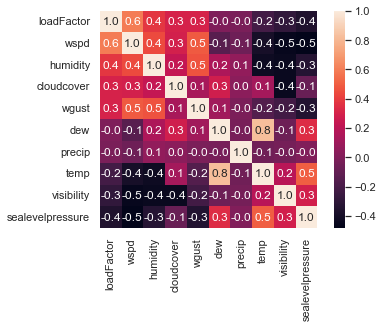

In [47]:

correlation = dataset.corr(method='pearson')
columns = correlation.nlargest(10, 'loadFactor').index

correlation_map = np.corrcoef(dataset[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.1f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()


From this we can adjust the data a bit more and then evaluate a range of different models.

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

#!@!!Copied code replace!!! - https://www.kaggle.com/junkal/selecting-the-best-regression-model


pipelines = []
pipelines.append(('ScaledLR',LinearRegression()))

pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM',GradientBoostingRegressor()))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=25)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -0.489337 (2.074428)
ScaledLASSO: -0.114138 (0.055453)
ScaledEN: -0.114138 (0.055453)
ScaledKNN: -0.075729 (0.037697)
ScaledCART: -0.098178 (0.051149)
ScaledGBM: -0.069262 (0.028549)


##### Latent Factors
Examine the possibiliy of using PCA or a deep neural network to improve predicitons by allowing the model to learn its own latent features.